<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Pipeline de Dados do Telegram II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Storytelling.</li>
</ol>

---

# **Exercícios**

## 1\. Ingestão

Replique as atividades da aula 1.

1.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados crus, não se esqueça de adicionar o sufixo `-raw`.

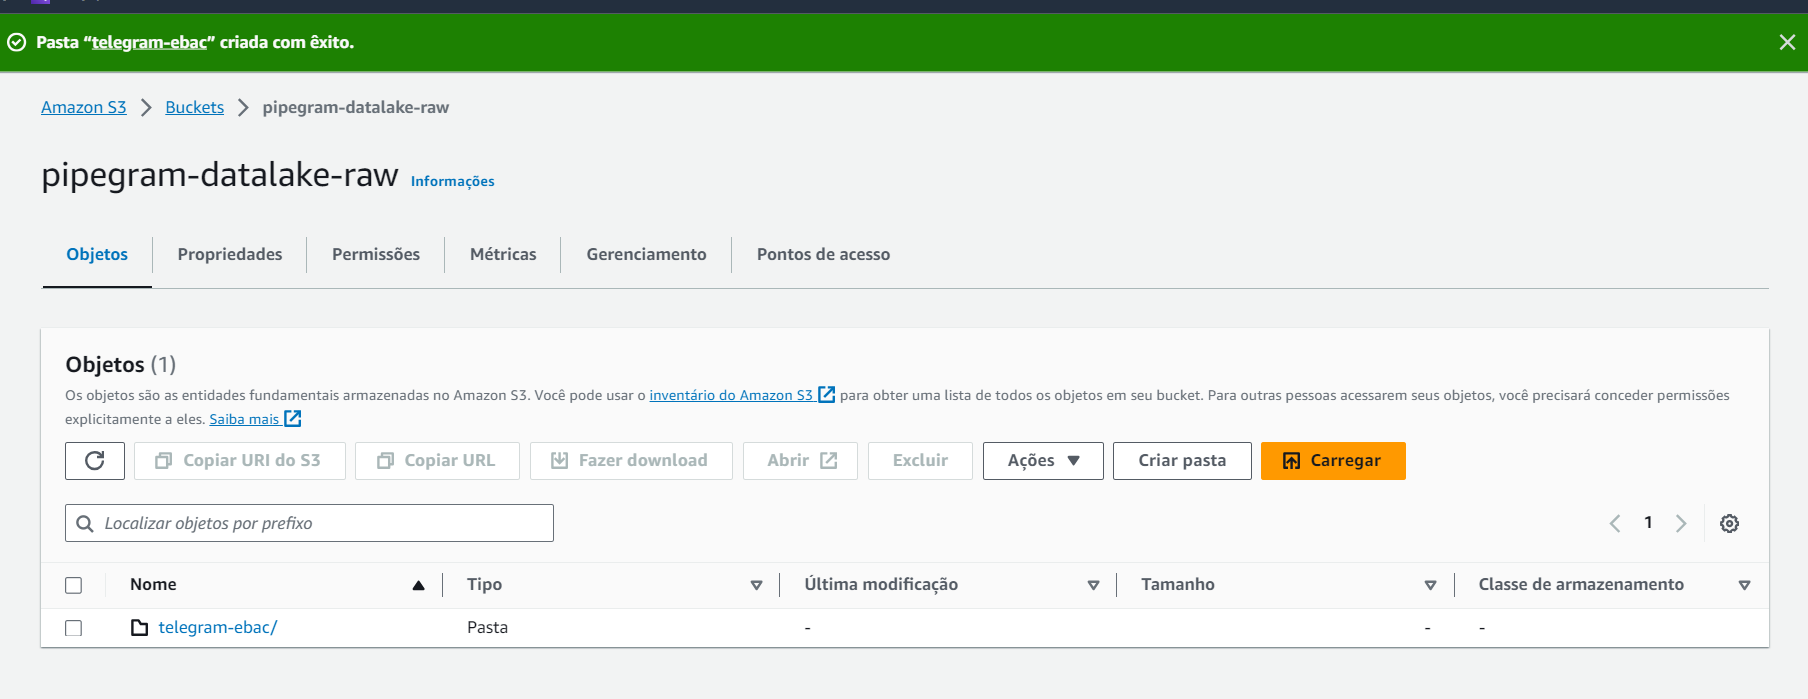

1.2. Crie uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. Não se esqueça de configurar as variáveis de ambiente e de adicionar as permissão de interação com `AWS S3` no `AWS IAM`.

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:
    message = event
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

In [ ]:
# JSON do evento
 {
  "update_id": 625037554,
  "message": {
    "message_id": 2,
    "from": {
      "id": 1087224674,
      "is_bot": false,
      "first_name": "Manatit",
      "username": "manatit"
    },
    "chat": {
      "id": -4003307830,
      "title": "Ebac_Group",
      "type": "group",
      "all_members_are_administrators": true
    },
    "date": 1700708560,
    "text": "Hello Horld!"
  }
}

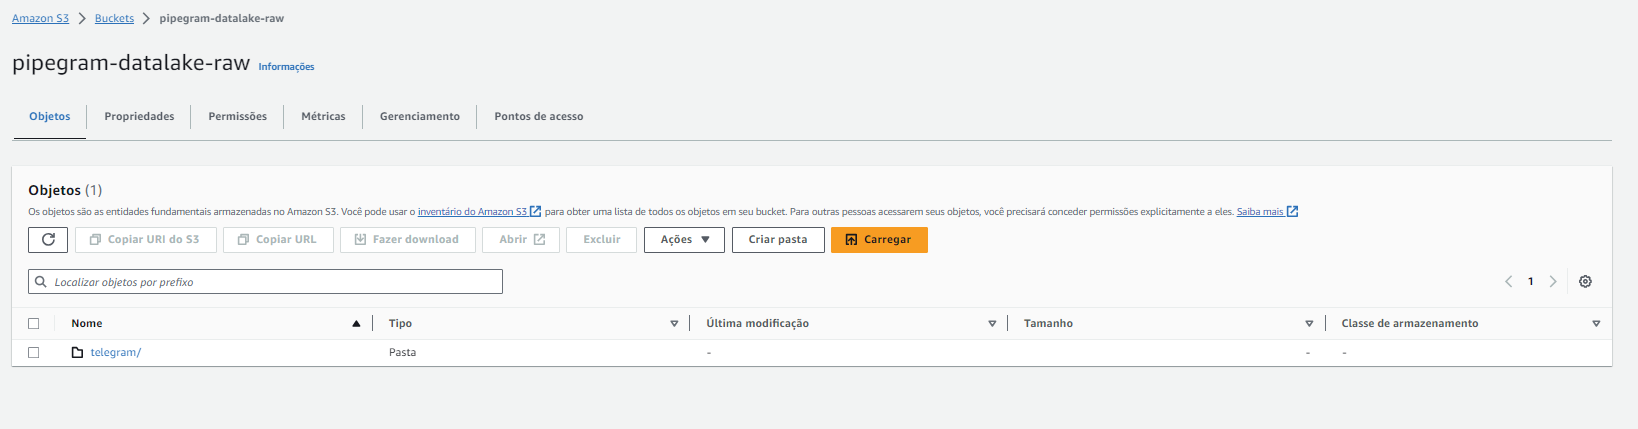

> **Nota**: Para testar a função com evento do próprio `AWS Lambda`, substitua o código `message = json.loads(event["body"])` por `message = event`. Lembre-se que o primeiro só faz sentido na integração com o `AWS API Gateway`.

1.3. Crie uma API no `AWS API Gateway` a conecte a função do `AWS Lambda`, conforme apresentado na aula.

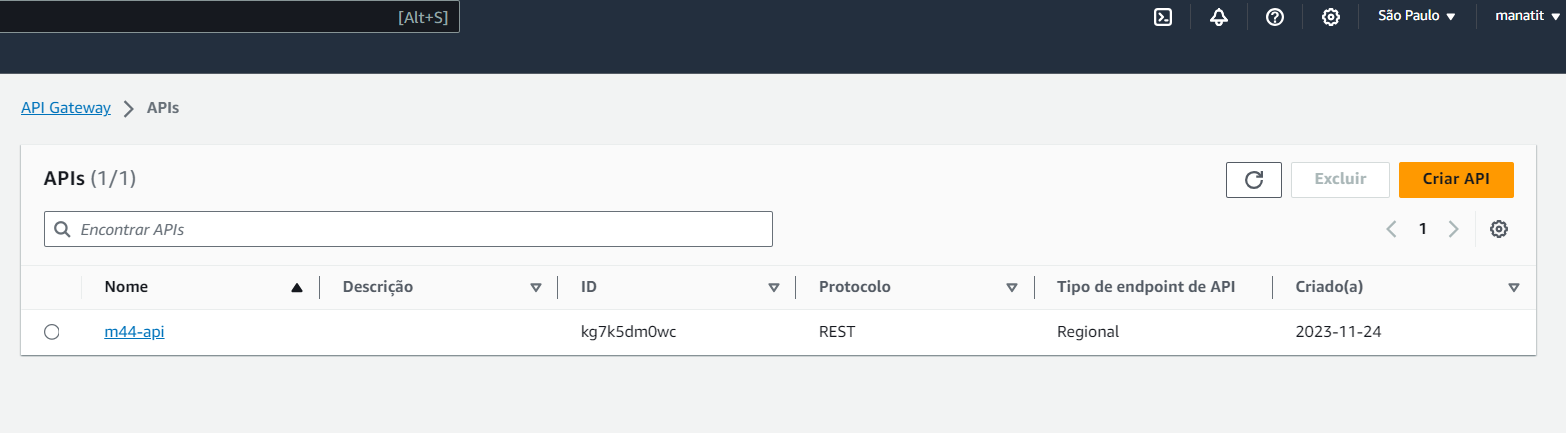> **Nota**: não disponibilize o endereço da API gerada.

In [ ]:
from getpass import getpass
aws_api_gateway_url = getpass()

··········


In [ ]:
token = getpass()

··········


In [ ]:
import json

base_url = f'https://api.telegram.org/bot{token}'

1.4. Configura o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. utilize o endereço da API criada no `AWS API Gateway`. Utilize o método `getWebhookInfo` para consultar a integração.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


> **Nota**: não disponibilize o *token* de acesso ao seu *bot* da API de *bots* do **Telegram**.

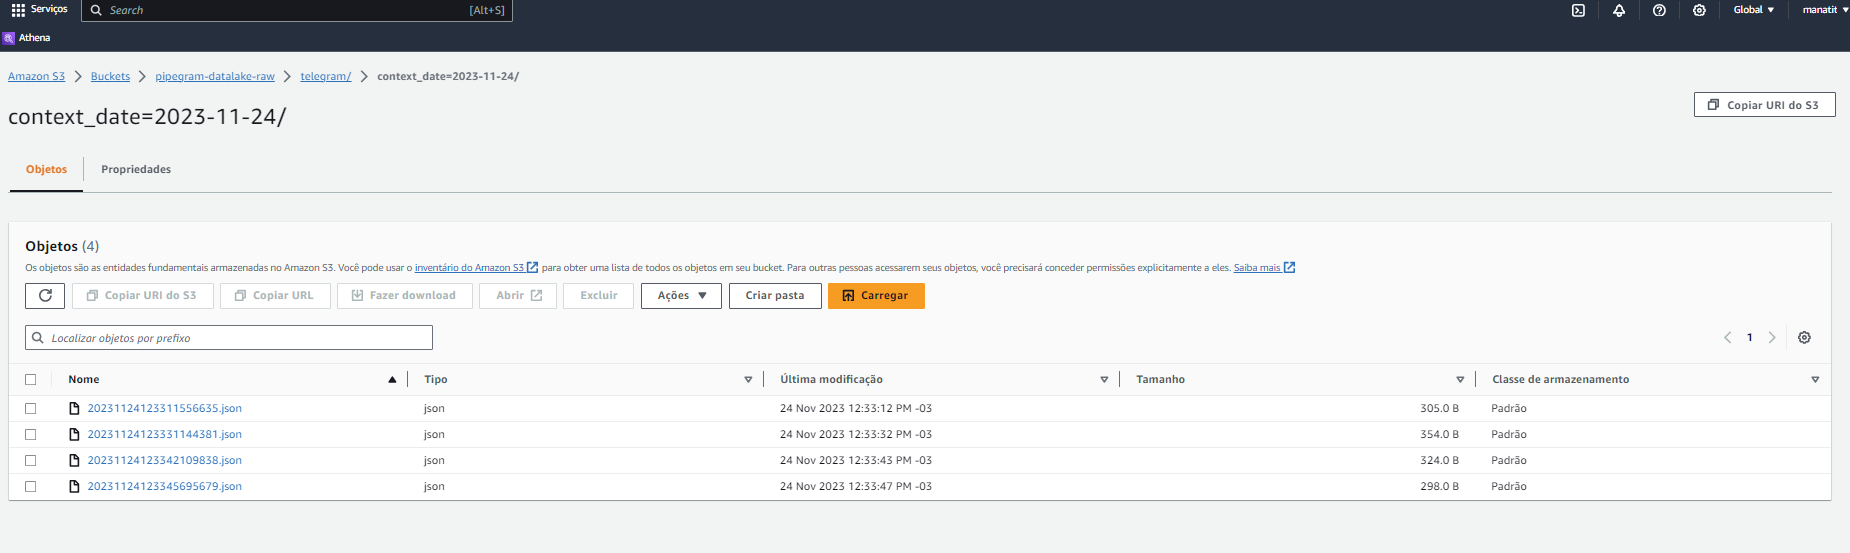

## 2\. ETL

Replique as atividades da aula 2.

2.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos, não se esqueça de adicionar o sufixo `-enriched`.

2.2. Cria uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. Salve o resultado em um único arquivo PARQUET, também particionado por dia. Não se esqueça de configurar as variáveis de ambiente, de adicionar as permissão de interação com `AWS S3` no `AWS IAM`, de configurar o *timeout* e de adicionar a *layer* com o código do pacote Python PyArrow.

> **Nota**: Para testar a função, substitua o código `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  #date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

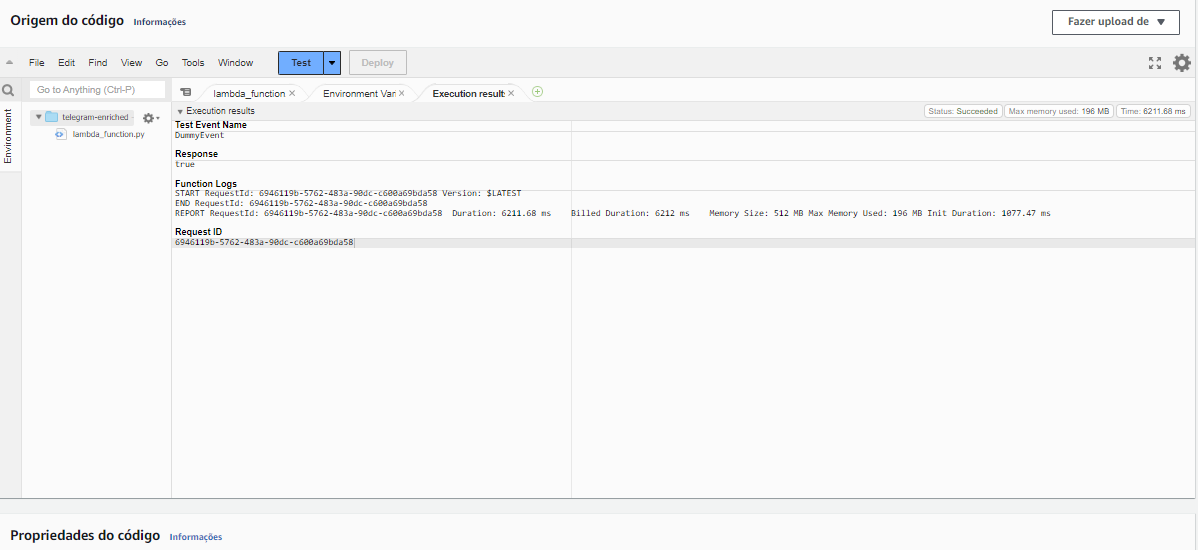

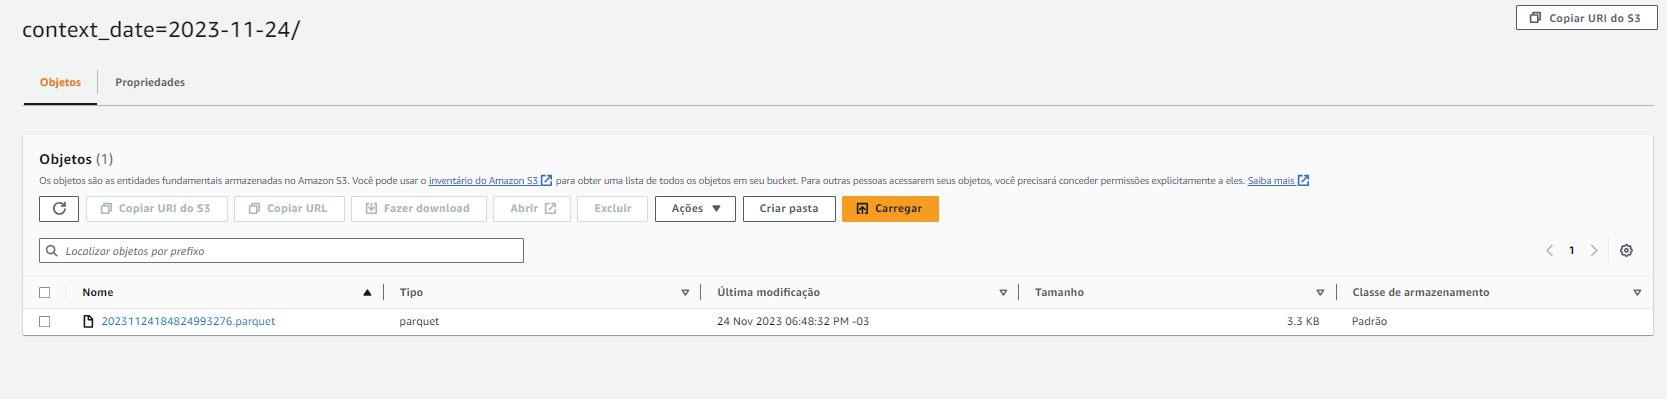

2.3. Crie uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

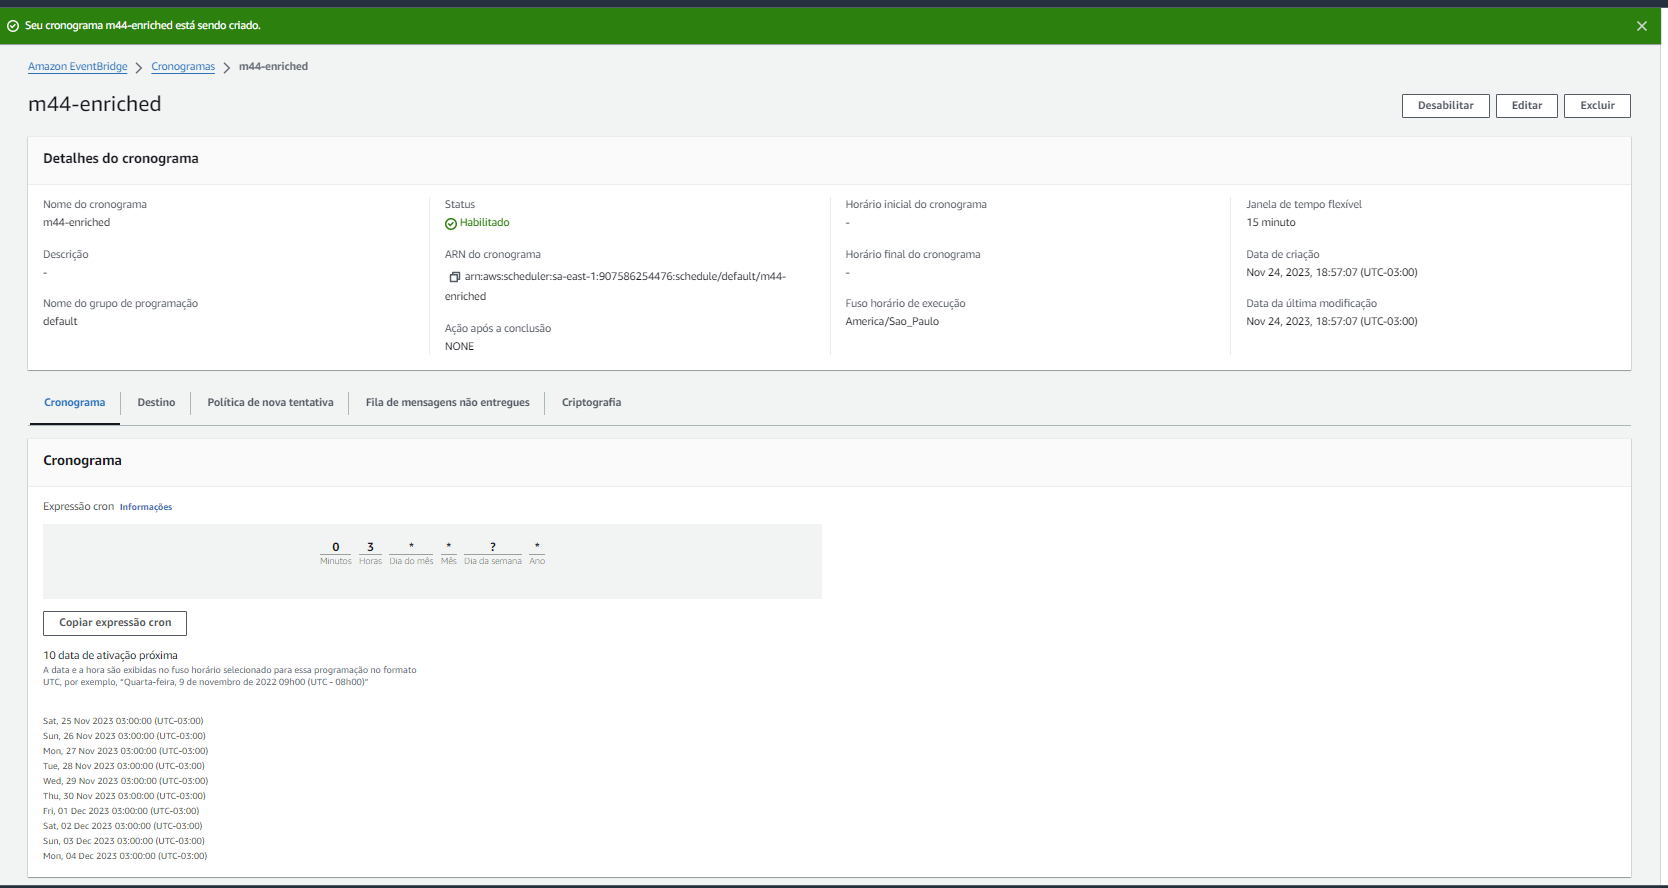

## 3\. Apresentação

Replique as atividades da aula 3.

3.1. Cria a tabela no `AWS Athena` que aponte para os dados armazenados no bucket enriquecido do `AWS S3`.

In [ ]:
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://m44-enriched/'

3.2. Execute o comando `MSCK REPAIR TABLE <nome-tabela>` para carregar as partições.

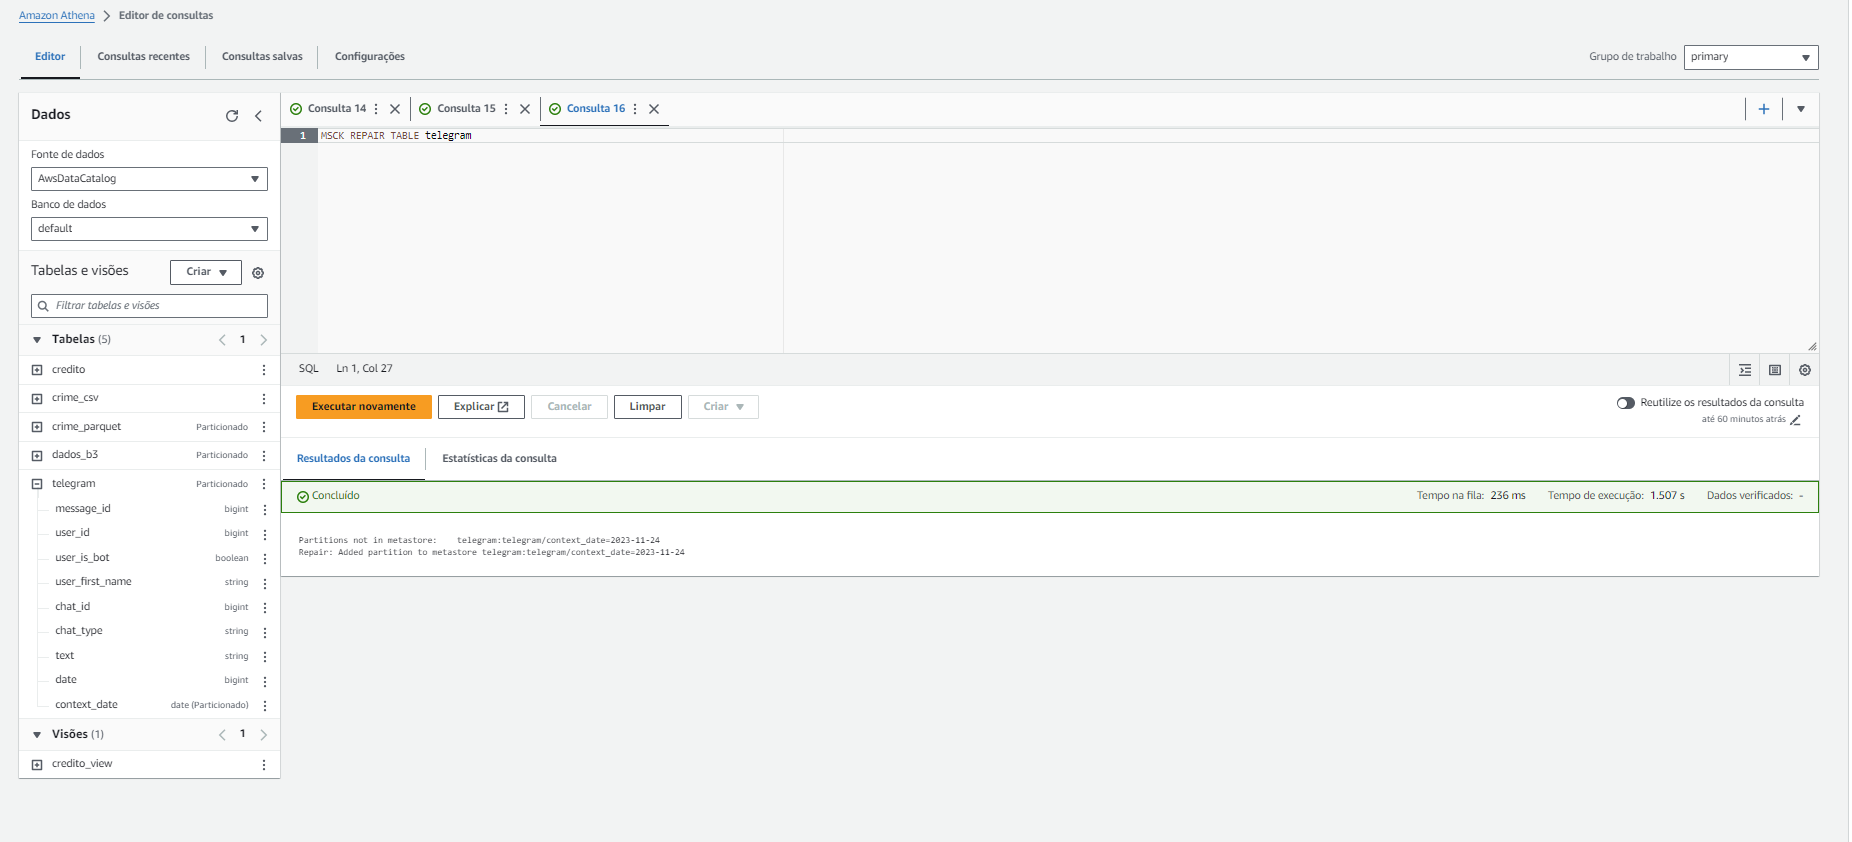

3.3. Execute as consultas SQL para explorar os dados.

```sql
--Quantidades de mensagens por dia
SELECT context_date, COUNT(*) AS messages
FROM telegram
GROUP BY context_date
ORDER BY 1 DESC;
```


|context_Date |  messages  |
|----------------|----------|
| 2023-11-24  | 4          |


```sql
--Média do tamanho das mensagens.
SELECT
  context_date,
  CAST(AVG(length(text)) AS INT) AS mean_message_len
FROM telegram
GROUP BY  context_date
ORDER BY 1 DESC;
````

|context_Date |  messages |
|-------------|-----------|
| 2023-11-24  | 28        |

```sql
--Quantas mensagens tiveram erros de digitação?
SELECT count(*) AS messages_with_typos
FROM telegram
WHERE text LIKE '%*%';
```

|messages_with_typos |
|-------------|
|0|

```sql
--Checagem:
SELECT user_first_name,
       text AS messages_with_typos,
       context_date
FROM telegram
ORDER BY 3 DESC;
```

|user_first_name |  messages_with_typos                                                    |  context_date|
|----------------|-------------------------------------------------------------------------|--------------|
| Manatit        | Olá Ebac Bot*                                                            |  2023-11-24  |
| Manatit        | Quero saber se você está salvando as mensagens no meu S3*                |  2023-11-24  |
| Manatit        | Espero que esteja tudo certo com vc*                                     |  2023-11-24  |
| Manatit        | Obrigado!*                                                               |  2023-11-24  |

## 4\. Storytelling

Siga as dicas da aula 4 para expor o seu projeto.

* **Contexto**

 O objetivo deste projecto foi implementar um pipeline dades para analisar mensagens em um grupo do telegram. O pipeline foi implementado utilizado serviços da Amzon Web Services (AWS).


* **Ferramentas utilizadas**

 ![Python](https://img.shields.io/badge/Python-black?style=flat-square&logo=python)
 ![Amazon AWS](https://img.shields.io/badge/AWS-black?style=flat-square&logo=amazon-aws)
![SQL](https://img.shields.io/badge/-SQL-black?style=flat-square&logo=sqlite)
![Telegram](https://img.shields.io/badge/-Telegram_Bots-blue?style=flat-square&logo=telegram)
[![ETL](https://img.shields.io/badge/-Extract_Transform_and_Load_(ETL)-crimson)](https://vinicius-oviedo.streamlit.app/)

     * O pipeline é ilustrado na célula seguinte

* **Conclusão**

Utilizando o serviço do AWS Athena e queries em SQL, é possível extrair insights acerca da mensagens enviadas diariamente via Telegram.

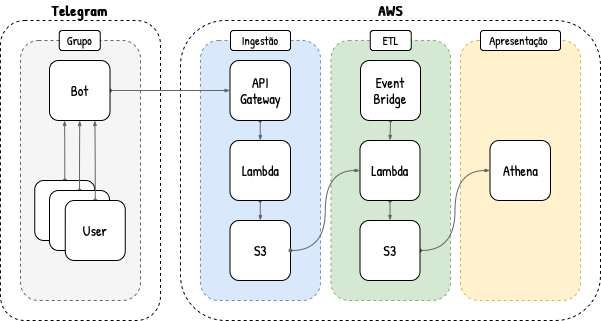